# Extreme Makeover: DSI Edition

In [3]:
import sys
!{sys.executable} -m pip install nltk

    100% |████████████████████████████████| 13.8MB 2.4MB/s ta 0:00:011
    100% |████████████████████████████████| 112kB 8.2MB/s ta 0:00:01
    100% |████████████████████████████████| 61kB 5.0MB/s ta 0:00:011


In [2]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
import nltk 
from nltk import word_tokenize
from nltk.corpus import stopwords
stop = stopwords.words('english')
import seaborn as sns

In [18]:
workshop_data = pd.read_csv("workshops.csv")
timestamp = pd.to_datetime(workshop_data['Timestamp'])
workshop_data['Timestamp'] = timestamp

### How to people find DSI?

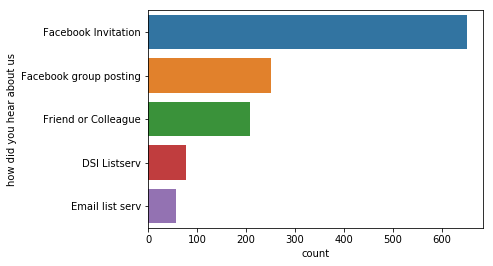

In [19]:
sns.countplot(data=workshop_data, y = 'how did you hear about us', order = workshop_data['how did you hear about us'].value_counts().iloc[:5].index)

### How often do members return?

/usr/local/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


Text(0.5,0.98,'Histogram of Number of Workshop Attendences by Email')

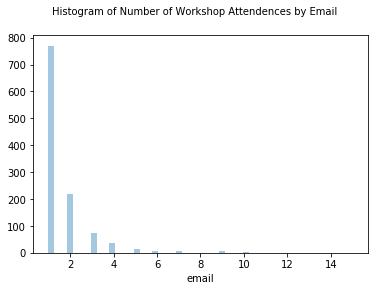

In [32]:
a = sns.distplot(workshop_data['email'].value_counts(), kde= False)
fig = a.figure
fig.suptitle("Histogram of Number of Workshop Attendences by Email", size=10)

### What is the academic standing of the workshop participants?

Text(0.5,0.98,"Proportion of Attendees' Academic Standing")

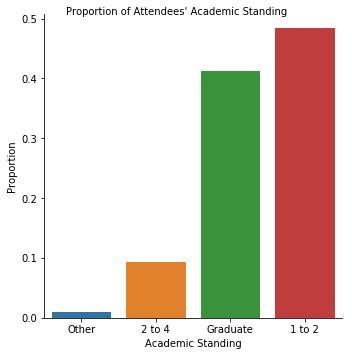

In [26]:
aca = workshop_data[["Timestamp", "Workshop_Type", 'first attendance', "academic standing"]].dropna(subset=['academic standing'])
acag = aca.groupby('academic standing').count().reset_index().sort_values('Timestamp')
acap = aca.groupby('academic standing').count().agg(lambda x: x/len(aca)).reset_index().sort_values('Timestamp')

g = sns.catplot(x='academic standing', y='Timestamp', kind='bar', data=acap)
g.set_axis_labels("Academic Standing", "Proportion")
fig = g.fig
fig.suptitle("Proportion of Attendees' Academic Standing", size=10)

### What do people think?

/usr/local/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


Text(0.5,0.98,'10 Most Positive Words and Their Counts; Most and Least Positive Words Used')

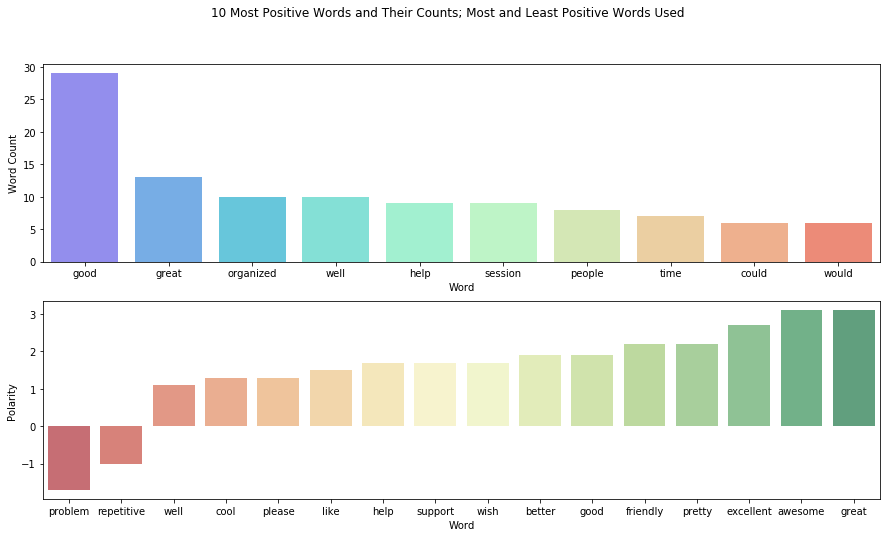

In [23]:
lexicon = pd.read_csv('vader_lexicon.txt',
                       sep='\t', 
                       header=None,
                       engine='python',
                       names=['token', 'polarity', 'sd', 'raw'])

sent = lexicon.drop({'sd','raw'},axis=1).set_index('token')
polarity = workshop_data[["Timestamp", "no_punc", "polarity", "Workshop_Type"]].drop(workshop_data.index[1634:]).dropna()

words = [i for i in nltk.tokenize.word_tokenize(polarity['no_punc'].str.cat(sep=' ')) if i not in stop]
word_dist = nltk.FreqDist(words)
freq = pd.DataFrame.from_dict(data=dict(word_dist), orient='index', columns=["freq"])

polarity2 = freq.join(lexicon.set_index('token')).dropna()
p2graph = (polarity2[(polarity2["freq"] > 1)]
           .sort_values('polarity').iloc[0:2,:]
           .append(polarity2[(polarity2["freq"] > 1)]
                   .sort_values('polarity', ascending=False)
                   .iloc[:,:].sort_values("polarity")))

#### ----

f, (ax1, ax2) = plt.subplots(2, 1, figsize=(15,8))

sns.color_palette("husl", 8)
sns.barplot(x="index", y='freq', 
            data=freq.sort_values("freq", ascending=False).iloc[0:10,:].reset_index(),
            palette=sns.color_palette("rainbow", 10), 
            alpha=0.7, ax=ax1)

sns.barplot(x="index", y='polarity', 
            data=p2graph.reset_index(), 
            palette="RdYlGn", 
            ax=ax2, alpha=0.7)

ax1.set_ylabel("Word Count")
ax1.set_xlabel("Word")
ax2.set_xlabel("Word")
ax2.set_ylabel("Polarity")
f.suptitle("10 Most Positive Words and Their Counts; Most and Least Positive Words Used")

### Proportion of 

Text(0,0.5,'')

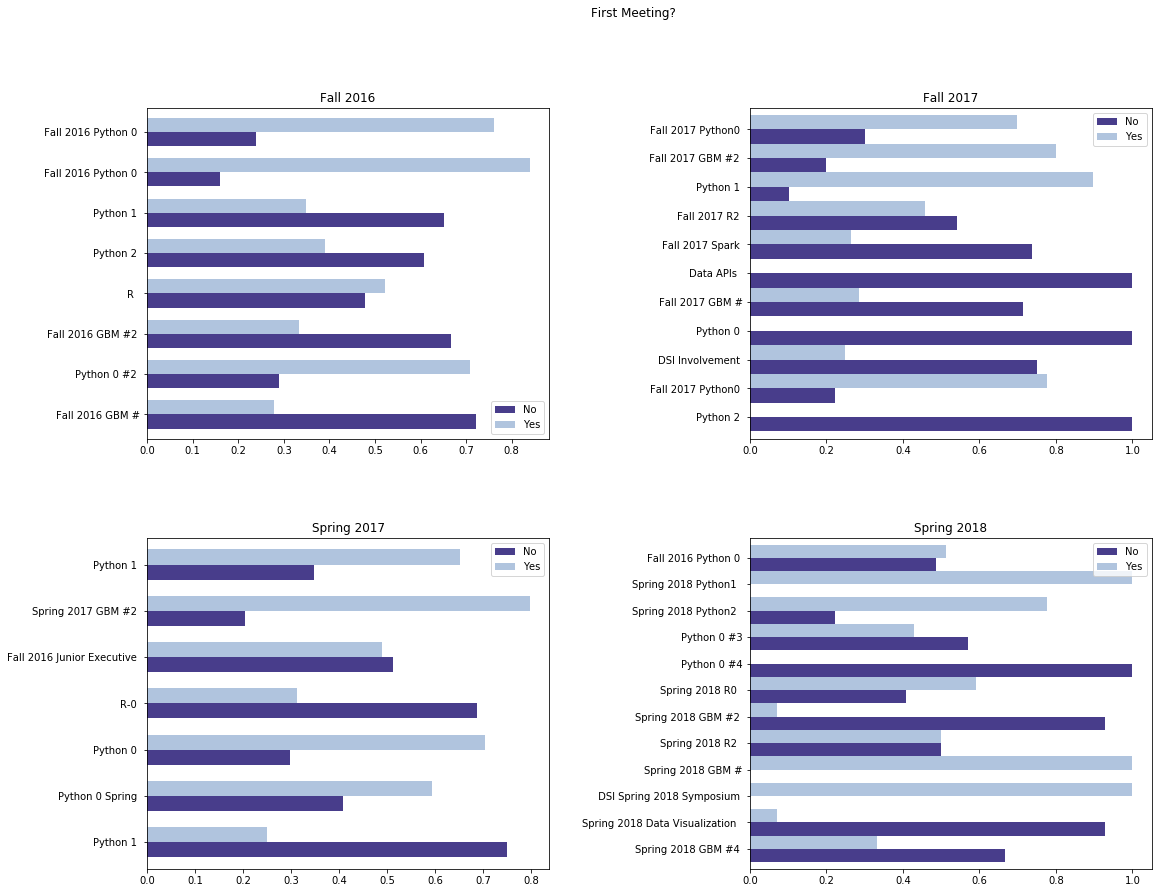

In [25]:
### proportion new, proportion not new 

atten = workshop_data[["Timestamp", "Workshop_Type", "past attendance", "first attendance"]].dropna(how='all')

atten["past"] = atten["past attendance"].map(dict(Yes=1, No=0))
atten["first"] = atten["first attendance"].map(dict(Yes=1, No=0))


atten1 = atten.set_index("Timestamp").loc['2016-07-01':'2017-01-01'].reset_index()
atten2 = atten.set_index("Timestamp").loc['2017-01-02':'2017-06-01'].reset_index()
atten3 = atten.set_index("Timestamp").loc['2017-06-02':'2018-01-01'].reset_index()
atten4 = atten.set_index("Timestamp").loc['2018-01-02':'2018-06-01'].reset_index()

lis = []
for i in [atten1, atten2, atten3, atten4]:
    lis.append(pd.Series(i.groupby("Workshop_Type").first().sort_values(
        "Timestamp").index).str.replace("Sign.*|Workshop|Copy of|Post.*|Board.*|SIGN IN|3.*", ""))

lis[3] = pd.Series(list(lis[3])[:8] + ['Python 0 #3', 'Python 0 #4'] + list(lis[3][8:])).str.replace("Workshop", "")
lis[2] = lis[2].str.replace("\(.*|Copy of|Workshop", "")

### ---

f, axes = plt.subplots(2, 2, figsize=(18,14))

f.suptitle("First Meeting?")

a1g = (atten1[~(atten1["Timestamp"]
                .dt.strftime('%Y-%m-%d') == ('2016-10-25'))]
                .resample("D", on="Timestamp").mean().dropna()
                .rename(columns={"past":"No", "first":"Yes"}).sort_index(ascending=False)
                .plot(kind='barh', title='Fall 2016', 
                      color=['darkslateblue', 'lightsteelblue'], 
                      width=.7,ax=axes[0,0])).set_yticklabels(list(lis[0])[::-1])

a2g = (atten2.resample("D", on="Timestamp").mean().dropna()
                .rename(columns={"past":"No", "first":"Yes"}).sort_index(ascending=False)
                .plot(kind='barh', title='Spring 2017',
                      color=['darkslateblue', 'lightsteelblue'], 
                      width=.65, ax=axes[1,0])).set_yticklabels(list(lis[1])[::-1])

a3g = (atten3.resample("D", on="Timestamp").mean().dropna()
                .rename(columns={"past":"No", "first":"Yes"}).sort_index(ascending=False)
                .plot(kind='barh', title='Fall 2017', color=['darkslateblue', 'lightsteelblue'],
                      width=1,ax=axes[0,1])).set_yticklabels(list(lis[2])[::-1])

a4g = (atten4.resample("D", on="Timestamp").mean().dropna()
                .rename(columns={"past":"No", "first":"Yes"}).sort_index(ascending=False)
                .plot(kind='barh', title='Spring 2018',color=['darkslateblue', 'lightsteelblue'],
                      width=1,ax=axes[1,1])).set_yticklabels(list(lis[3])[::-1])

plt.subplots_adjust(hspace=.3, wspace=0.5)
axes[0,0].set_ylabel("")
axes[0,1].set_ylabel("")
axes[1,0].set_ylabel("")
axes[1,1].set_ylabel("")